# Mads notebook: General model inversion problem

## Problem setup

Import Mads

In [1]:
import Mads

┌ Info: Precompiling Mads [d6bdc55b-bd94-5012-933c-1f73fc2ee992]
└ @ Base loading.jl:1317


Mads: Model Analysis & Decision Support
====

    ___      ____            ____    ____              ______
   /   \    /    \          /    |  |    \            /  __  \
  |     \  /     |         /     |  |     \          /  /  \__\
  |  |\  \/  /|  |        /      |  |      \        |  |
  |  | \    / |  |       /  /|   |  |   |\  \        \  \______.
  |  |  \__/  |  |      /  / |   |  |   | \  \        \_______  \
  |  |        |  |     /  /  |   |  |   |  \  \               \  \
  |  |        |  |    /  /===|   |  |   |___\  \    __.        |  |
  |  |        |  |   /  /    |   |  |           \   \  \______/  /
  |__|        |__|  /__/     |___|  |____________\   \__________/

MADS is an integrated high-performance computational framework for data- and model-based analyses.
MADS can perform: Sensitivity Analysis, Parameter Estimation, Model Inversion and Calibration, Uncertainty Quantification, Model Selection and Model Averaging, Model Reduction and Surrogate Modeling, Machine L

  ** incremental compilation may be fatally broken for this module **

    Updating registry at `~/.julia/registries/General`
┌ Warning: could not download https://pkg.julialang.org/registries
└ @ Pkg.Types /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Pkg/src/Types.jl:980
   Resolving package versions...
[ Info: Module BIGUQ is not available!
┌ Info: Installing pyqt package to avoid buggy tkagg backend.
└ @ PyPlot /Users/vvv/.julia/packages/PyPlot/XHEG0/src/init.jl:118


Create a problem dictionary:

In [2]:
md = Dict()

Dict{Any, Any}()

Setup model parameters:

In [3]:
md["Parameters"] = Mads.createmadsparameters([1,1,1,1]; key=["a", "b", "c", "n"], dist=["Uniform(-10, 10)", "Uniform(-10, 10)", "Uniform(-5, 5)", "Uniform(-3, 3)"])

OrderedCollections.OrderedDict{Any, Any} with 4 entries:
  "a" => OrderedCollections.OrderedDict{String, Any}("init"=>1, "type"=>"opt", …
  "b" => OrderedCollections.OrderedDict{String, Any}("init"=>1, "type"=>"opt", …
  "c" => OrderedCollections.OrderedDict{String, Any}("init"=>1, "type"=>"opt", …
  "n" => OrderedCollections.OrderedDict{String, Any}("init"=>1, "type"=>"opt", …

There are 4 model parameters (`a`, `b`, `c`, and `n`). The initial values and the prior distributions of the parameters are defined for each parameter.

In [5]:
md["Observations"] = Mads.createmadsobservations([0,1.1,1.9,3.1,3.9,5]; weight=[1,1,1,1,1,0], time=[0,1,2,3,4,5], dist=["Uniform(0, 1)", "Uniform(0, 2)", "Uniform(1, 3)", "Uniform(2, 4)", "Uniform(3, 5)", "Uniform(4, 6)"])

dist = ["Uniform(0, 1)", "Uniform(0, 2)", "Uniform(1, 3)", "Uniform(2, 4)", "Uniform(3, 5)", "Uniform(4, 6)"]


OrderedCollections.OrderedDict{Any, Any} with 6 entries:
  "o1" => OrderedCollections.OrderedDict{String, Any}("target"=>0.0, "weight"=>…
  "o2" => OrderedCollections.OrderedDict{String, Any}("target"=>1.1, "weight"=>…
  "o3" => OrderedCollections.OrderedDict{String, Any}("target"=>1.9, "weight"=>…
  "o4" => OrderedCollections.OrderedDict{String, Any}("target"=>3.1, "weight"=>…
  "o5" => OrderedCollections.OrderedDict{String, Any}("target"=>3.9, "weight"=>…
  "o6" => OrderedCollections.OrderedDict{String, Any}("target"=>5.0, "weight"=>…

There are 6 observations (`o1`, `o2`, `o3`, ... and `o6`). The calibration targets, observation weights (i.e., inverse of measurement standard deviations), and acceptable ranges are defined for each observation.

A function (called `polynominal`) is defined to compute the 6 observations given 4 parameters as an input:

In [8]:
function polynominal(parameters::AbstractVector)
	f(t) = parameters[1] * (t ^ parameters[4]) + parameters[2] * t + parameters[3] # a * t^n + b * t + c
	predictions = map(f, 0:5)
	return predictions
end

polynominal (generic function with 1 method)

The function is setup now in the `md` dictionary as a function that will be applied to perform model simulation:

In [9]:
Mads.createmadsexecutable!(md, polynominal)

(::Mads.var"#madscommandfunctionwithexpressions#159") (generic function with 1 method)

In [10]:
display(md)

Dict{Any, Any} with 3 entries:
  "Julia function" => polynominal
  "Parameters"     => OrderedCollections.OrderedDict{Any, Any}("a"=>OrderedColl…
  "Observations"   => OrderedCollections.OrderedDict{Any, Any}("o1"=>OrderedCol…

Now the problem is setup!

## Forward model simulation

A single forward model run based on the initial model parameters cane be executed as follows:

In [11]:
Mads.forward(md)

OrderedCollections.OrderedDict{Any, Float64} with 6 entries:
  "o1" => 1.0
  "o2" => 3.0
  "o3" => 5.0
  "o4" => 7.0
  "o5" => 9.0
  "o6" => 11.0

The initial model predctions can be plotted as well:

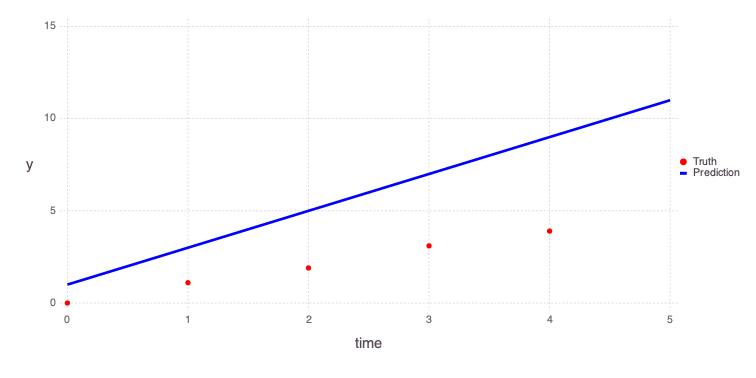

In [13]:
Mads.plotmatches(md)

The figure above shows that the `true` observations are not well reproduced by the model using the initial model parameter guesses.

The forward model run can be also executed using the following command (not recommended):

In [14]:
polynominal(Mads.getparamsinit(md))

6-element Vector{Float64}:
  1.0
  3.0
  5.0
  7.0
  9.0
 11.0

## Model calibration (inversion)

The calibation (inversion) of the developed model is achieved using the following command:

In [15]:
calib_param, calib_result = Mads.calibrate(md)

(OrderedCollections.OrderedDict("a" => 0.6256803226615766, "b" => 0.41174389306488735, "c" => 0.007161248225937555, "n" => 0.9333357469539947), OptimBase.MultivariateOptimizationResults{LsqFit.LevenbergMarquardt, Float64, 1}(LsqFit.LevenbergMarquardt(), [0.10016742116155988, 0.10016742116155988, 0.20135792079033074, 0.33983690945412187], [0.06260892747426644, 0.041186032222910604, 0.001432250134859606, 0.31636278655144184], 0.03296094110975696, 5, false, true, 0.0001, 0.0, false, 0.001, 0.0, false, 1.0e-6, 0.0, false, Iter     Function value   Gradient norm 
------   --------------   --------------
, 71, 5, 0))

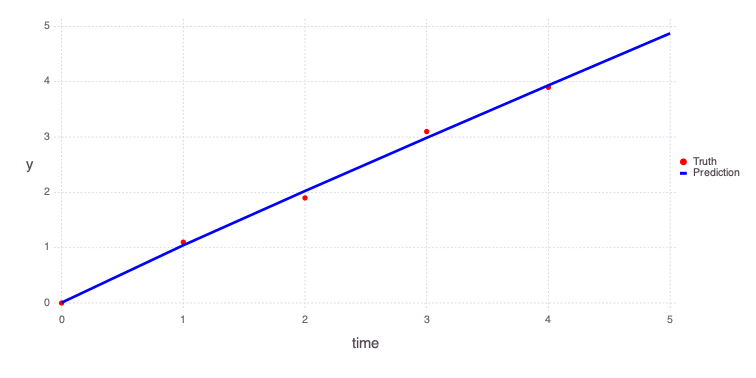

In [16]:
Mads.plotmatches(md, calib_param)

Initial values of the model parameters are:

In [18]:
Mads.showparameterestimates(md)

a =         0.62568 distribution = Uniform(-10, 10) 
b =        0.411744 distribution = Uniform(-10, 10) 
c =      0.00716125 distribution = Uniform(-5, 5) 
n =        0.933336 distribution = Uniform(-3, 3) 
Number of optimizable parameters: 4


Estimated values of the model parameters based on the model calibration (inversion) are:

In [17]:
Mads.showparameterestimates(md, calib_param)

a =         0.62568 distribution = Uniform(-10, 10) 
b =        0.411744 distribution = Uniform(-10, 10) 
c =      0.00716125 distribution = Uniform(-5, 5) 
n =        0.933336 distribution = Uniform(-3, 3) 
Number of optimizable parameters: 4


## Evaluation of posterior uncertainties

In [19]:
chain, llhoods = Mads.emceesampling(md; numwalkers=10, nsteps=100000, burnin=10000, thinning=10, seed=2016, sigma=0.01)

([-0.5161681161514753 0.4310534503605993 … 1.3435463956432714 -6.037274929257502; 1.099993870797083 0.21053553308081496 … 0.14021892507891523 6.42210283505251; 0.5669485175185572 0.02950657976720434 … -0.9756470623036929 1.8169811174159847; 0.6755641814397039 1.4687373559971677 … 0.9002988581678445 0.9881481861254896], [-10.574736991454202, -10.486785949222988, -13.182145642280403, -10.41445533247353, -12.669515403168115, -11.204527258147843, -12.542495751389929, -11.705958635715827, -11.22715953608083, -11.896260451018438  …  -11.661853782683567, -13.151676887561747, -11.585825923354202, -11.132019231238198, -10.612265161164753, -12.800807452056192, -12.106692065717652, -10.359122622585183, -11.531204881108028, -15.251841613490315])

In [21]:
f = Mads.forward(md, chain)

6×10000 Matrix{Float64}:
 0.566949  0.0295066  0.317173  0.438424  …  0.255834  -0.975647  1.81698
 1.15077   0.671096   0.58877   0.983947     0.758063   0.508118  2.20181
 1.9425    1.64365    2.0211    1.89364      1.75992    1.81246   2.68542
 2.78271   2.82531    3.67446   2.99384      2.86572    3.05748   3.20576
 3.65012   4.17382    5.44587   4.23414      4.02819    4.26567   3.74982
 4.53586   5.66502    7.29431   5.58779   …  5.22815    5.44727   4.31146

In [24]:
Mads.spaghettiplot(md, permutedims(f))

StackOverflowError:┌ Warning: 2021-06-25 16:39:18 Spaghettiplot: Gadfly fails!
└ @ Mads /Users/vvv/.julia/dev/Mads/src/MadsLog.jl:53
StackOverflowError:┌ Warning: Gadfly failed!
└ @ Mads /Users/vvv/.julia/dev/Mads/src-interactive/MadsDisplay.jl:92
